In [35]:
import warnings

warnings.filterwarnings('ignore')  # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx

pd.set_option('display.max_columns', None)  # 当列太多时不换行
df = pd.read_parquet('cb_data.pq')  # 导入转债数据
index = pd.read_parquet('index.pq')  # 导入指数数据
from numpy import nan

df.head()
# df.columns

name  pre_close    open    high     low   close  \
code      trade_date                                                    
110030.SH 2018-01-02  格力转债     105.28  105.30  106.18  105.30  105.40   
          2018-01-03  格力转债     105.40  105.40  105.72  105.40  105.46   
          2018-01-04  格力转债     105.46  105.50  105.73  105.30  105.60   
          2018-01-05  格力转债     105.60  106.08  109.86  105.71  109.34   
          2018-01-08  格力转债     109.34  109.31  111.89  108.73  109.76   

                       pct_chg      vol     amount  volatility   code_stk  \
code      trade_date                                                        
110030.SH 2018-01-02  0.001140   9075.0   958.0068    0.103224  600185.SH   
          2018-01-03  0.000569   9783.0  1031.8907    0.103226  600185.SH   
          2018-01-04  0.001328   8676.0   915.2612    0.103057  600185.SH   
          2018-01-05  0.035417  47628.0  5166.3701    0.109005  600185.SH   
          2018-01-08  0.003841  31285.0  3455.6852    0.108986  600185.SH   

                     name_stk  pre_close_stk  open_stk  high_stk  low_stk  \
code      trade_date                                                        
110030.SH 2018-01-02     格力地产           5.68      5.66      5.89     5.66   
          2018-01-03     格力地产           5.77      5.74      5.83     5.70   
          2018-01-04     格力地产           5.79      5.78      5.84     5.74   
          2018-01-05     格力地产           5.80      5.82      6.26     5.82   
          2018-01-08     格力地产           6.15      6.13      6.44     6.08   

                      close_stk  pct_chg_stk    vol_stk  amount_stk   pe_ttm  \
code      trade_date                                                           
110030.SH 2018-01-02       5.77     0.015845  123240.77   71342.620  18.2321   
          2018-01-03       5.79     0.003466  112470.22   64885.787  18.2952   
          2018-01-04       5.80     0.001727   86917.89   50287.495  18.3269   
          2018-01-05       6.15     0.060345  506597.49  307682.959  19.4328   
          2018-01-08       6.27     0.019512  565535.31  356757.949  19.8120   

                          pb  ps_ttm  dv_ratio  total_share  float_share  \
code      trade_date                                                       
110030.SH 2018-01-02  1.5625  3.6100  0.003466  206007.7575  206007.7575   
          2018-01-03  1.5679  3.6225  0.003454  206007.7575  206007.7575   
          2018-01-04  1.5706  3.6288  0.003448  206007.9508  206007.9508   
          2018-01-05  1.6654  3.8477  0.003252  206007.9508  206007.9508   
          2018-01-08  1.6979  3.9228  0.003190  206007.9508  206007.9508   

                        total_mv     circ_mv  debt_to_assets  volatility_stk  \
code      trade_date                                                           
110030.SH 2018-01-02  118.866476  118.866476        0.719948        0.294814   
          2018-01-03  119.278492  119.278492        0.719948        0.294711   
          2018-01-04  119.484611  119.484611        0.719948        0.294694   
          2018-01-05  126.694890  126.694890        0.719948        0.300755   
          2018-01-08  129.166985  129.166985        0.719948        0.301309   

                      pct_chg_5  pct_chg_5_stk    bias_5 is_call  conv_price  \
code      trade_date                                                           
110030.SH 2018-01-02  -0.001421       0.032200 -0.033621                7.24   
          2018-01-03   0.000949       0.032086 -0.031136                7.24   
          2018-01-04   0.007345       0.048825 -0.041479                7.24   
          2018-01-05   0.045815       0.110108 -0.064293                7.24   
          2018-01-08   0.042553       0.103873 -0.061320                7.24   

                      conv_value  conv_prem       dblow  issue_size  \
code      trade_date                                                  
110030.SH 2018-01-02   79.696133   0.322523  137.652340         9.8   
 

In [36]:
# 基础设置
start_date = '20220801'  # 开始日期
end_date = '20240325'  # 结束日期
hold_num = 5  # 持有数量
threadhold_num = 5  # 轮动阈值
c_rate = 2 / 1000  # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl'  # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000
shares_per_board_lot = 10  # 每手数量(最小交易单位)

In [37]:
# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (
        df.index.get_level_values('trade_date') <= end_date)]  # 选择时间范围内数据
df['filter'] = False  # 初始化过滤器

df['close_pct'] = df.groupby('trade_date')['close'].rank(pct=True)  # 将收盘从小到大百分比排列

df.loc[df.is_call.isin(
    ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True  # 排除赎回状态
# df.loc[df.list_days <= 1, 'filter'] = True # 排除新债
df.loc[df.left_years < 0.5, 'filter'] = True  # 排除到期日小于1年的标的

# df.loc[df.conv_prem >0.5 , 'filter'] = True # 排除溢价率
# df.loc[df.remain_size > 10, 'filter'] = True # 排除剩余规模
# df.loc[df.rating.isin(
#     ['BBB+', 'BBB', 'BBB+', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-']), 'filter'] = True  # 排除评级
df.loc[df.close > 150, 'filter'] = True  # 排除价格
df.loc[df.close < 100, 'filter'] = True  # 排除价格
#df.loc[df.ps_ttm < 0, 'filter'] = True # 排除市盈率
#df.loc[df.ps_ttm < 0, 'filter'] = True # 排除市销率
# df.loc[df.pb < 0, 'filter'] = True # 排除市净率
# df.loc[df.close_pct > 0.8, 'filter'] = True # 排除收盘价高于x%的标的

In [38]:
# 计算多因子得分 和 排名(score总分越大越好， rank总排名越小越好)

# 生成因子字典，name:列名，weight:权重, ascending:排序方向
rank_factors =[{'name': 'volatility_stk', 'weight': 1, 'ascending': False},
 {'name': 'pb', 'weight': 4, 'ascending': True},
 {'name': 'conv_prem', 'weight': 2, 'ascending': False},
 {'name': 'yy_rating', 'weight': 2, 'ascending': False}]

In [39]:
# 计算多因子得分 和 排名(score总分越大越好， rank总排名越小越好)
trade_date_group = df[df['filter'] == False].groupby('trade_date')
for factor in rank_factors:
    if factor['name'] in df.columns:
        df[f'{factor["name"]}_score'] = trade_date_group[factor["name"]].rank(ascending=factor['ascending']) * factor[
            'weight']
    else:
        print(f'未找到因子【{factor["name"]}】, 跳过')

df['score'] = df[df.filter(like='score').columns].sum(axis=1, min_count=1)
if hold_num >= 1:
    df['rank'] = df.groupby('trade_date')['score'].rank('first', ascending=False)
else:
    df['rank_pct'] = df.groupby('trade_date')['score'].rank('first', ascending=False, pct=False)

In [40]:
# 阈值轮动
if threadhold_num:
    df.rename(columns={'rank': 'ori_rank'}, inplace=True)  # 记录原排名
    df['rank'] = nan  # 初始化排名
    df['mod_rank'] = nan  # 初始化修正排名
    RANK_INDEX = df.columns.get_loc('rank')  # 排名下标值
    ORI_RANK_INDEX = df.columns.get_loc('ori_rank')  # 原始排名下标值
    df.iloc[df.index.get_level_values(1) == df.index.get_level_values(1)[0], RANK_INDEX] = df.iloc[
        df.index.get_level_values(1) == df.index.get_level_values(1)[0], ORI_RANK_INDEX]  # 首日排名等于原排名

    trade_date_list = df.index.get_level_values('trade_date').unique()  # 交易日列表

    # 遍历每个交易日对排名进行处理
    for trade_date, _df in df.groupby('trade_date'):
        # 跳过首日
        if trade_date == df.index.get_level_values(1)[0]:
            continue
        last_trade_date = trade_date_list[trade_date_list.get_loc(trade_date) - 1]  # 上个交易日日期

        # 构建一个包含当日原始排名（ori_rank）、上个交易日排名（last_rank）、修正排名（mod_rank）和重新排序后的最终排名（rank）的_ranks_df
        _ranks_df = df.loc[df.index.get_level_values('trade_date') == trade_date, ['ori_rank']] \
            .merge(df.loc[df.index.get_level_values('trade_date') == last_trade_date, 'rank'], how='left', on='code') \
            .rename(columns={'rank': 'last_rank'})

        # 若上一交易日排名last_rank <= hold_num，今日mod_rank = ori_rank - threadhold_num，否则今日mod_rank = ori_rank
        _ranks_df['mod_rank'] = (_ranks_df['ori_rank'] - threadhold_num).where(_ranks_df['last_rank'] <= hold_num,
                                                                               _ranks_df['ori_rank'])
        # 根据mod_rank 重新排序出今日rank
        _ranks_df['rank'] = _ranks_df['mod_rank'].rank(method='first')

        # 将今日最终排名rank写入原df
        df.loc[df.index.get_level_values('trade_date') == trade_date, ['mod_rank', 'rank']] = _ranks_df[
            ['mod_rank', 'rank']].values


In [41]:
# 检查核对使用
#df['last_rank'] = df.groupby('code').shift(1)['rank'] # 计算上个交易日排名
#df.loc[df.index.get_level_values('trade_date')=='2023-09-01']# 查看某日情况


In [42]:
# 计算每日信号 采样信号 持仓状态
code_group = df.groupby('code')
df['time_return'] = code_group.pct_chg.shift(-1)  # 计算标的每日回报
df.loc[(df['rank'] <= hold_num), 'signal'] = 1  # 标记信号
df.dropna(subset=['signal'], inplace=True)  # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True)  # 按日期排序

In [43]:
# 计算组合回报
res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean()  # 按等权计算组合回报
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate  # 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1  # 扣除手续费及佣金后的回报

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2022-08-02   2022-08-02
End Period          2024-03-22   2024-03-22
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   -11.7%       -4.58%
CAGR﹪              -5.11%       -1.95%

Sharpe              -0.72        -0.11
Prob. Sharpe Ratio  18.22%       44.65%
Sortino             -0.96        -0.17
Sortino/√2          -0.68        -0.12
Omega               0.98         0.98

Max Drawdown        -19.68%      -27.17%
Longest DD Days     583          415

Gain/Pain Ratio     -0.11        -0.02
Gain/Pain (1M)      -0.38        -0.08

Payoff Ratio        1.15         1.04
Profit Factor       0.89         0.98
Common Sense Ratio  0.77         1.1
CPC Index           0.5          0.46
Tail Ratio          0.86         1.12
Outlier Win Ratio   4.79         2.89
Outlier Loss Ratio  3.83         2.94

MTD                 2.02%        2.26%
3M      

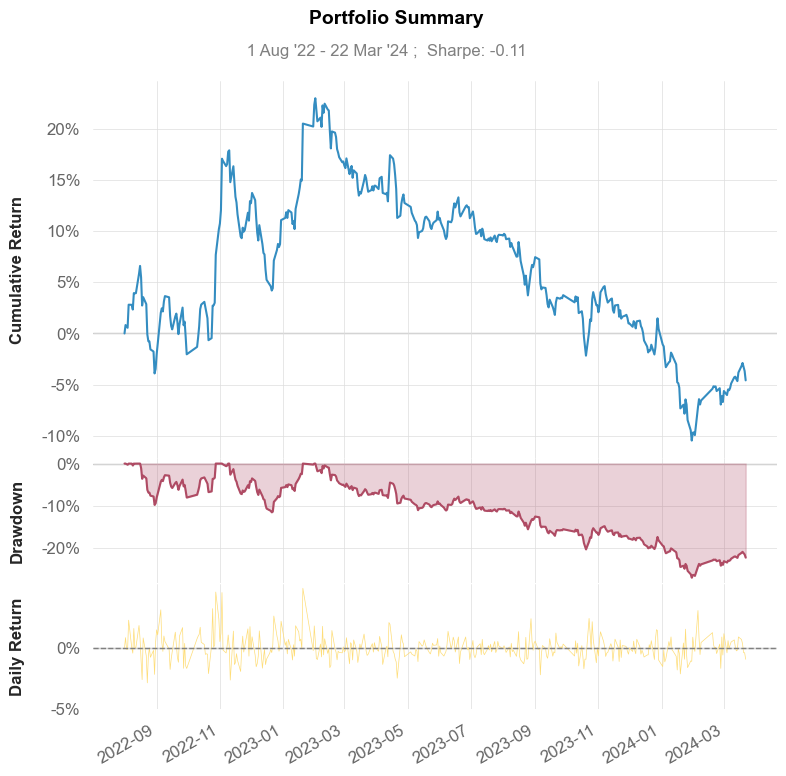

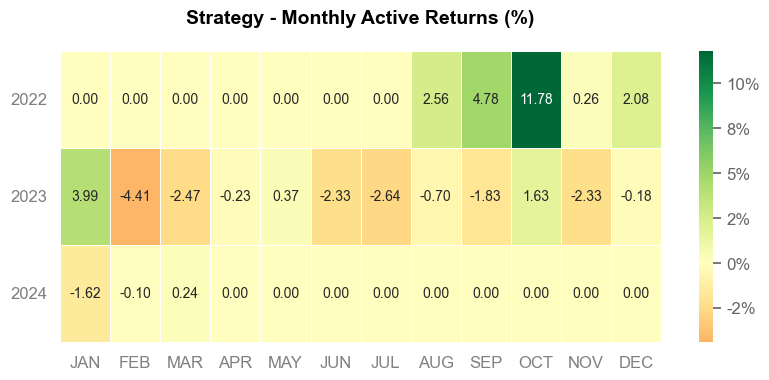

In [44]:
# 用quantstats生成评价报告
import quantstats as qs

qs.reports.basic(res['time_return'], benchmark=index[benchmark])

In [45]:
cagr = qs.stats.cagr(res['time_return'])
print("CAGR: {:.2%}".format(cagr))

CAGR: -2.45%
